In [1]:
library(tidyverse) # Add the tidyverse package to my current library.
library(haven) # Handle labelled data.
library(essurvey) # Add ESS API package.
library(lme4) # For regression with robust SE
library(estimatr) # For regression with robust SE
library(parameters) # Library with many useful tools
library(texreg) # For nicely-formatted regression tables
library(iimm) # Numerical df approximation
library(modelr)
library(influence.ME)
library(webshot)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Version:  1.38.6
Date:     2022-04-06
Author:   Philip Leifeld (University of Essex)

Consider submitting praise using the praise or praise_interactive functions.
Please cite the JSS article in your publications -- see citation("texreg").


Attaching package: 'texreg'


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'influence.ME'


The follow

In [2]:
# Small self-written function for z-standardization
std <- function(x) {
  (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)
}


# A small function to calculate ICC from a lme4 model. 
# Dependencies: broom.mixed, dplyr, lme4
icc <- function(model){
  icc <- data.frame(broom.mixed::tidy(model, effects=c("ran_pars"))) %>%
    mutate(variance = estimate^2) %>%
    mutate(icc = variance / sum(variance)) %>%
    filter(term == "sd__(Intercept)")
  return(icc$icc)
}



In [3]:
# RI 

In [4]:
# import data
# macro-level predictor: Proportion of immigrants (Eurostat data)

ESS <-read_dta("C:/Users/10292/Desktop/Xeno_data/ESS7e02_2.dta")%>%
  recode_missings() %>%
  inner_join(., read.csv("C:/Users/10292/Desktop/Xeno_data/rate.csv", header=T, na.strings=c("NA")), by = "cntry")

In [5]:
# Add re-scaled post-stratification weights to ESS
ESS <- rescale_weights(data = ESS,
                       group = "cntry", 
                       probability_weights = "pspwght")


In [6]:
# outcome variable: General xenophobia 
#B34 - is [country] made a worse or better place to live by people coming to live here from other countries? 
#(0 Worse place to live)
ESS <- ESS %>%
  mutate(
    xeno = (max(imwbcnt, na.rm = TRUE) - imwbcnt) %>% std())
#larger xeno -> more xenophobia

In [7]:
#individual-level predictor: misperception
#perception: D16 Out of every 100 people living in [country], how many do you think were born outside [country]?
ESS<- ESS %>%
  mutate(    
    est_rate = zap_labels(noimbro),
    diff_rate = (est_rate - immi_rate) %>% std())

#individual-level control variables
# Media news consumption: A1 TV watching, total time on average weekday(0 No time at all)
# Place of residence: F14 Which phrase on this card best describes the area where you live (1 A big city)
# Age: F31b
# Education: F16
# Close friends from different race or ethnic group (1 Yes, several)
ESS <- ESS %>%
  mutate(    
    media = zap_labels(tvtot)%>% std(),# larger -> more consumption
    residence = (max(domicil, na.rm = TRUE) - domicil)%>% std(),# larger -> biger city
    age = zap_labels(agea)%>% std(),
    education = zap_labels(eduyrs)%>% std(),
    friends=(max(dfegcf, na.rm = TRUE) - dfegcf)%>% std()) # larger -> more those friends



In [8]:
# country-level variables:
# predictor(micro-level contextual effect): National identification：D22 How close do you feel to [country]? (1 Very close)
# control variables : Economic insecurity: F42 Feeling about household's income nowadays (1 Living comfortably on present income)

ESS <- ESS %>%
  mutate(    
    national_iden = max(fclcntr, na.rm = TRUE) - fclcntr,# larger -> closer
    econ_inse = zap_labels(hincfel)) # larger -> more insecure



In [9]:
# Generate average by country, 
ESS_cnt<- ESS%>% group_by(cntry) %>%
summarize(xeno.j = mean(xeno, na.rm = TRUE),
          national_iden.j = mean(national_iden, na.rm = TRUE),
          econ_inse.j=mean(econ_inse,na.rm=TRUE)) %>%drop_na()

ESS_cnt <- ESS_cnt %>%
  mutate(    
    xeno.j = xeno.j %>% std(),
    national_iden.j = national_iden.j %>% std(),
    econ_inse.j = econ_inse.j %>% std()
  )

In [10]:
data <-  left_join(ESS, ESS_cnt, by = "cntry")%>% # & conjoin to micro-level data.
  # Keep only the following variables
  select(cntry, xeno,xeno.j,econ_inse.j,national_iden.j,est_rate,diff_rate,econ_inse,media,residence,age,friends,education,pweights_a) %>%
  drop_na() 

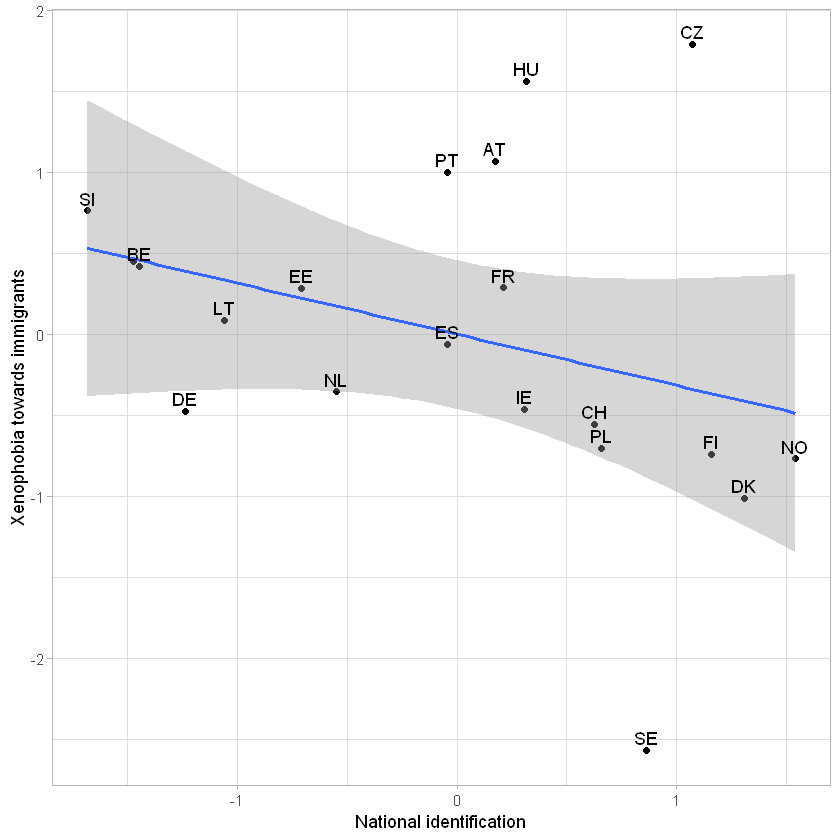

In [11]:
p<-ggplot(ESS_cnt, aes(x = national_iden.j, y = xeno.j, label = cntry)) + 
  geom_point() + 
  geom_smooth(method = "lm", formula = "y ~ x") + #By default, it is the 95% confidence level interval for predictions from a linear model ("lm").
  geom_text(vjust=-0.4, check_overlap = TRUE) +
  labs(y = "Xenophobia towards immigrants", x = "National identification") +
  theme_light()

p
ggsave("national_iden vs xeno.png", dpi= 600, width = 4, height = 4)

In [12]:
#empty

ri_empty <- lmer(xeno ~ (1 | cntry), data = data,weights = pweights_a)
                 
htmlreg(
  list(ri_empty), 
  file="ri_empty.html", 
  include.ci = FALSE, 
  custom.coef.names = c(
    "Intercept"
  ),
  custom.model.names = c(
    "RI empty"
  ),
  digits = 3,
  caption = "",
  custom.gof.rows = list("ICC" = c(
    paste0(round(icc(ri_empty)*100, digits=2),"%")
  )
  )
)
webshot("ri_empty.html", "ri_empty.png")

The table was written to the file 'ri_empty.html'.




In [13]:
#RI

In [14]:
ri_mod3 <- lmer(xeno ~ diff_rate+national_iden.j+age+education+friends+residence+media+econ_inse.j+(1 | cntry), data = data,weights = pweights_a)

ri_mod3_t <- lmer_t(ri_mod3, method = "Heuristic") # Alternativelym, method = "Heuristic" for M-l-1 rule.
summary(ri_mod3_t)

ri_mod3_o <- texreg::extract(ri_mod3)
ri_mod3_o@pvalues <- summary(ri_mod3_t)$coef[,7]



Linear mixed model fit by REML ['lmerMod']
   t-tests use the Heuristic method.
Formula: xeno ~ diff_rate + national_iden.j + age + education + friends +  
    residence + media + econ_inse.j + (1 | cntry)
   Data: data
Weights: pweights_a

REML criterion at convergence: 90655.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3934 -0.6007 -0.0196  0.5614  4.9910 

Random effects:
 Groups   Name        Variance Std.Dev.
 cntry    (Intercept) 0.03502  0.1871  
 Residual             0.83890  0.9159  
Number of obs: 32832, groups:  cntry, 20

Coefficients:
                Estimate Std.Err t value    Df  Lower   Upper   Pr(>|t|)     
(Intercept)      0.0042  0.0422    0.1004    17 -0.0847  0.0932 0.92121      
diff_rate        0.0953  0.0055   17.2430 32825  0.0845  0.1061 < 2.2e-16 ***
national_iden.j -0.0390  0.0443   -0.8805    17 -0.1324  0.0544 0.39087      
age              0.0262  0.0056    4.7036 32825  0.0153  0.0371 2.566e-06 ***
education       -0.1515  0.0057  -2

In [15]:
#RIS  

In [16]:
ris_mod0 <- lmer(xeno ~ diff_rate +(1+ diff_rate| cntry), data = data,weights = pweights_a)
ris_mod0_t <- lmer_t(ris_mod0, method = "Heuristic") # Alternativelym, method = "Heuristic" for M-l-1 rule.
summary(ris_mod0_t)
ris_mod0_o <- texreg::extract(ris_mod0)
ris_mod0_o@pvalues <- summary(ris_mod0_t)$coef[,7]

Linear mixed model fit by REML ['lmerMod']
   t-tests use the Heuristic method.
Formula: xeno ~ diff_rate + (1 + diff_rate | cntry)
   Data: data
Weights: pweights_a

REML criterion at convergence: 93142.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5027 -0.6056  0.0136  0.5462  4.3560 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 cntry    (Intercept) 0.070239 0.26503      
          diff_rate   0.005375 0.07331  0.07
 Residual             0.904708 0.95116      
Number of obs: 32832, groups:  cntry, 20

Coefficients:
            Estimate Std.Err t value    Df  Lower   Upper   Pr(>|t|)     
(Intercept) -0.0237  0.0596   -0.3987 32830 -0.1405  0.0930 0.6901       
diff_rate    0.0930  0.0175    5.3043 32830  0.0587  0.1274 1.138e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [17]:
ris_mod1 <- lmer(xeno ~ national_iden.j+diff_rate +(1+ diff_rate| cntry), data = data,weights = pweights_a)
ris_mod1_t <- lmer_t(ris_mod1, method = "Heuristic") # Alternativelym, method = "Heuristic" for M-l-1 rule.
summary(ris_mod1_t)
ris_mod1_o <- texreg::extract(ris_mod1)
ris_mod1_o@pvalues <- summary(ris_mod1_t)$coef[,7]

Linear mixed model fit by REML ['lmerMod']
   t-tests use the Heuristic method.
Formula: xeno ~ national_iden.j + diff_rate + (1 + diff_rate | cntry)
   Data: data
Weights: pweights_a

REML criterion at convergence: 93145.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5026 -0.6053  0.0134  0.5462  4.3560 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 cntry    (Intercept) 0.072022 0.2684       
          diff_rate   0.005358 0.0732   0.03
 Residual             0.904710 0.9512       
Number of obs: 32832, groups:  cntry, 20

Coefficients:
                Estimate Std.Err t value    Df  Lower   Upper   Pr(>|t|)     
(Intercept)     -0.0238  0.0603   -0.3945    18 -0.1505  0.1029 0.6978       
national_iden.j -0.0429  0.0618   -0.6939    18 -0.1728  0.0870 0.4966       
diff_rate        0.0930  0.0175    5.3079 32830  0.0586  0.1273 1.116e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [18]:
ris_mod2 <- lmer(xeno ~ diff_rate+national_iden.j+age+education+friends+residence+media+(1+ diff_rate| cntry), data = data,weights = pweights_a)
ris_mod2_t <- lmer_t(ris_mod2, method = "Heuristic") # Alternativelym, method = "Heuristic" for M-l-1 rule.
summary(ris_mod2_t)
ris_mod2_o <- texreg::extract(ris_mod2)
ris_mod2_o@pvalues <- summary(ris_mod2_t)$coef[,7]

Linear mixed model fit by REML ['lmerMod']
   t-tests use the Heuristic method.
Formula: xeno ~ diff_rate + national_iden.j + age + education + friends +  
    residence + media + (1 + diff_rate | cntry)
   Data: data
Weights: pweights_a

REML criterion at convergence: 90547.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.2399 -0.6029 -0.0185  0.5612  5.0249 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 cntry    (Intercept) 0.053674 0.23168      
          diff_rate   0.004732 0.06879  0.17
 Residual             0.835035 0.91380      
Number of obs: 32832, groups:  cntry, 20

Coefficients:
                Estimate Std.Err t value    Df  Lower   Upper   Pr(>|t|)     
(Intercept)     -0.0068  0.0521   -0.1311    18 -0.1164  0.1027 0.8972       
diff_rate        0.0808  0.0165    4.8851 32825  0.0484  0.1132 1.039e-06 ***
national_iden.j -0.0504  0.0527   -0.9561    18 -0.1612  0.0604 0.3517       
age              0.0278  0.0056    4.9860 32825  0.0169

In [19]:
ris_mod3 <- lmer(xeno ~ diff_rate+national_iden.j+age+education+friends+residence+media+econ_inse.j+(1+ diff_rate| cntry), data = data,weights = pweights_a)
ris_mod3_t <- lmer_t(ris_mod3, method = "Heuristic") # Alternativelym, method = "Heuristic" for M-l-1 rule.
summary(ris_mod3_t)
ris_mod3_o <- texreg::extract(ris_mod3)
ris_mod3_o@pvalues <- summary(ris_mod3_t)$coef[,7]

Linear mixed model fit by REML ['lmerMod']
   t-tests use the Heuristic method.
Formula: xeno ~ diff_rate + national_iden.j + age + education + friends +  
    residence + media + econ_inse.j + (1 + diff_rate | cntry)
   Data: data
Weights: pweights_a

REML criterion at convergence: 90538.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.2243 -0.6028 -0.0180  0.5615  5.0226 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 cntry    (Intercept) 0.040156 0.2004       
          diff_rate   0.004816 0.0694   0.65
 Residual             0.835031 0.9138       
Number of obs: 32832, groups:  cntry, 20

Coefficients:
                Estimate Std.Err t value    Df  Lower   Upper   Pr(>|t|)     
(Intercept)     -0.0072  0.0452   -0.1603    17 -0.1026  0.0881 0.8745342    
diff_rate        0.0812  0.0167    4.8764 32825  0.0486  0.1139 1.085e-06 ***
national_iden.j  0.0095  0.0377    0.2510    17 -0.0700  0.0889 0.8048338    
age              0.0279  0.0056    5.0122

In [20]:
ris_mod4 <- lmer(xeno ~ diff_rate*national_iden.j+age+education+friends+residence+media+econ_inse.j+(1+ diff_rate| cntry), data = data,weights = pweights_a)
ris_mod4_t <- lmer_t(ris_mod4, method = "Heuristic") # Alternativelym, method = "Heuristic" for M-l-1 rule.
summary(ris_mod4_t)
ris_mod4_o <- texreg::extract(ris_mod4)
ris_mod4_o@pvalues <- summary(ris_mod4_t)$coef[,7]

Linear mixed model fit by REML ['lmerMod']
   t-tests use the Heuristic method.
Formula: xeno ~ diff_rate * national_iden.j + age + education + friends +  
    residence + media + econ_inse.j + (1 + diff_rate | cntry)
   Data: data
Weights: pweights_a

REML criterion at convergence: 90543.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.2320 -0.6026 -0.0180  0.5613  5.0226 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 cntry    (Intercept) 0.039908 0.19977      
          diff_rate   0.004676 0.06838  0.65
 Residual             0.835040 0.91381      
Number of obs: 32832, groups:  cntry, 20

Coefficients:
                          Estimate Std.Err t value    Df  Lower   Upper  
(Intercept)               -0.0077  0.0450   -0.1701    17 -0.1027  0.0874
diff_rate                  0.0808  0.0165    4.9091 32825  0.0485  0.1130
national_iden.j           -0.0209  0.0469   -0.4457    17 -0.1198  0.0780
age                        0.0279  0.0056    5.0005 32825

In [21]:
#Output results

In [22]:
# Final
htmlreg(
  list(ri_mod3_o,ris_mod0_o,ris_mod1_o,ris_mod2_o,ris_mod3_o,ris_mod4_o), 
  file="final.html", 
  include.ci = FALSE, 
  custom.coef.names = c(
    "Intercept",
    "Misperception",
    "National Identity",
    "Age",
    "Education",
      "Cross-ethnic Friends",
    "Residence",
        "Media Consumption",
      "Economic Insecurity",
      "National_Identity:Misperception"
  ),
  custom.model.names = c(
    "Model 1 RI", "Model 2 RIS", "Model 3 RIS" ,"Model 4 RIS" ,"Model 5 RIS", "Model 6 RIS"
  ),
  groups = c(
    "Intercept" = list(1:1),
    "Individual level predictor" = list(2:2),
      "Country level predictor" = list(3:3),
          "Individual level control variables" = list(4:8),
      "Country level control variables" = list(9:9),
      "Cross-level interactions"= list(10:10)
    
  ),
  digits = 3,
  caption = ""
  )


webshot("final.html", "final.png")

The table was written to the file 'final.html'.




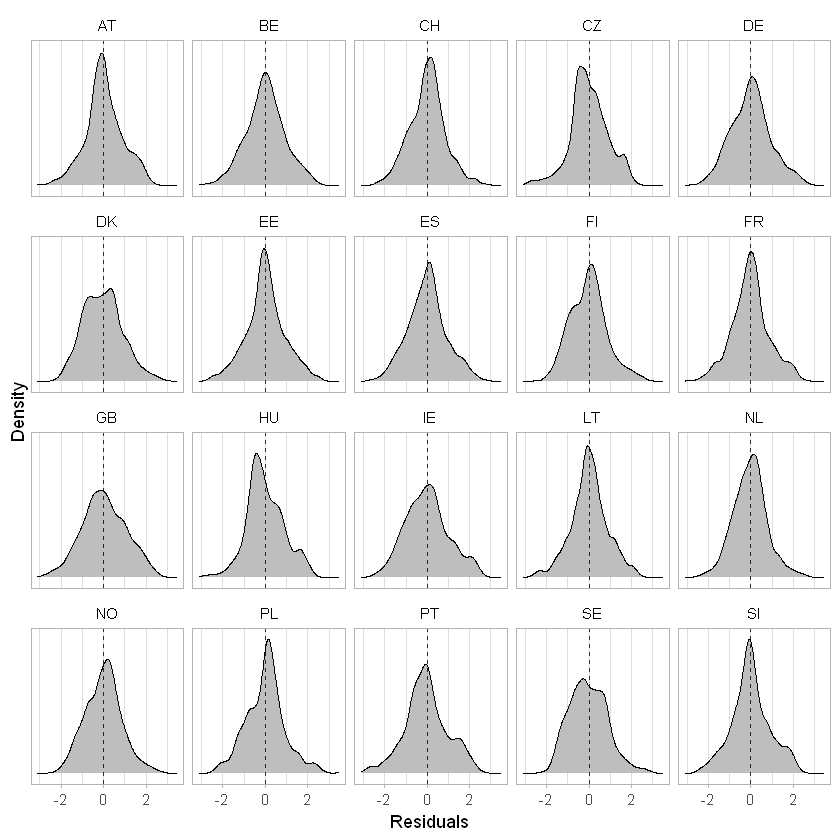

In [23]:
### Residual plot ###

data_res <- data %>%
  mutate(preds = predict(ris_mod4)) %>%
  mutate(res = xeno - preds)

p <- ggplot(data_res, aes(x=res, fill = "1")) +
geom_density() +
  geom_vline(xintercept = 0, alpha=0.8, linetype='dashed') +
  scale_fill_manual(values = c("gray")) +
  scale_y_discrete(expand=c(0.08, 0)) +
  labs(y="Density", x = "Residuals") +
  facet_wrap(~cntry, nrow=4) +
  theme_light() %+% theme(
    strip.background =element_rect(fill="white"), 
    strip.text = element_text(colour = 'black'),
    legend.position = "none")

p

ggsave("residuals.png", dpi= 600, width = 8, height = 3)


In [24]:
#Systematic macro outlier analysis


# Estimate -j models
one_out_models <- influence(model = ris_mod4, group = "cntry")
# Calculate the DFBETAs and turn into tibble
(DFBETAs <- dfbetas(one_out_models) %>% 
    data.frame() %>% 
    rownames_to_column() %>% 
    as_tibble() %>%
    select(rowname, national_iden.j, diff_rate, 
           diff_rate.national_iden.j))


DFBETAs <- pivot_longer(
  DFBETAs, 
  cols = c("national_iden.j", "diff_rate",
           "diff_rate.national_iden.j"), 
  names_to = "Variable")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00389516 (tol = 0.002, component 1)"
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00582993 (tol = 0.002, component 1)"
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00773541 (tol = 0.002, component 1)"
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00241019 (tol = 0.002, component 1)"
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00502055 (tol = 0.002, component 1)"


rowname,national_iden.j,diff_rate,diff_rate.national_iden.j
<chr>,<dbl>,<dbl>,<dbl>
AT,0.044838075,0.24772523,0.0440126031
BE,-0.127914092,0.07483686,-0.0668937834
CH,-0.003487759,-0.12942020,-0.0837430660
CZ,0.723561354,0.22580009,0.2351414532
DE,0.015119432,0.06945330,-0.1345319163
DK,0.297858030,0.41236751,0.5404040668
EE,0.137575051,-0.22203966,0.2260756063
ES,-0.013300675,0.21749037,0.0044013501
FI,-0.220581433,-0.16694386,-0.1870555295


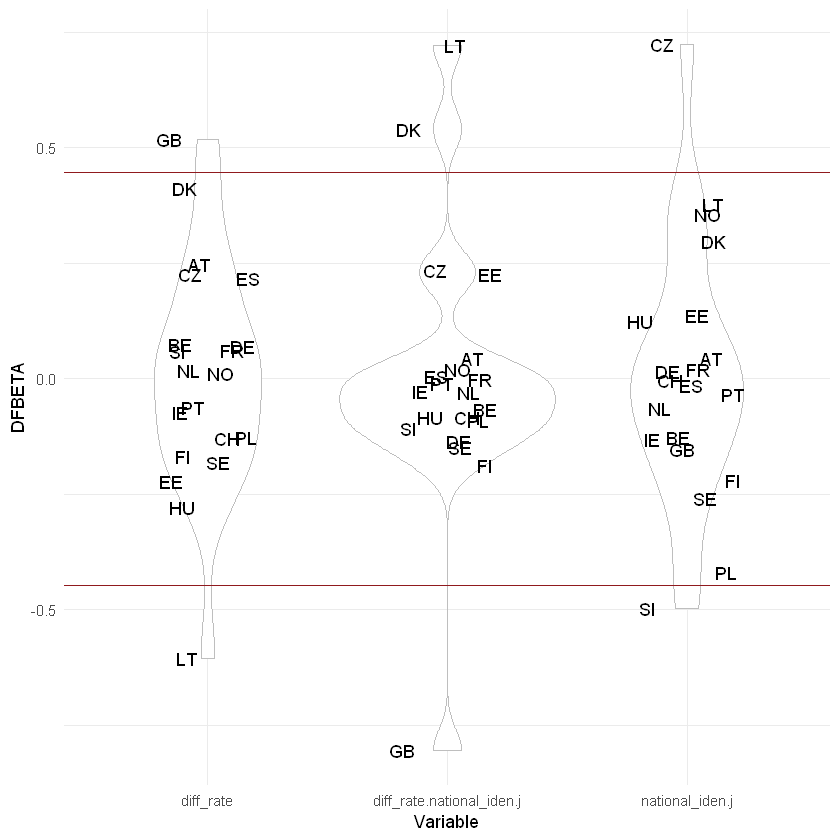

In [25]:
p<-ggplot(data = DFBETAs, 
       aes(y = value, x = Variable, label = rowname)) +
  geom_violin(color = "gray") +
  geom_text(position=position_jitter(width=0.2,height=0)) +
  geom_hline(yintercept = 2/sqrt(20), color = "#901A1E") +
  geom_hline(yintercept = -2/sqrt(20), color = "#901A1E") +
  theme_minimal() +
  labs(y = "DFBETA")

p
ggsave("outliers.png", dpi= 600, width =5, height =8 )

In [26]:
# BLUP for RIs
blups <- as.data.frame(ranef(ris_mod4) %>% as_tibble()) %>% 
  spread(term, condval) %>%
  mutate(grp = as.character(grp)) %>%
  group_by(grp) %>%
  summarise(Intercept = `(Intercept)`[which(!is.na(`(Intercept)`))[1]],
            Slope = diff_rate[which(!is.na(diff_rate))[1]]) %>%
  arrange(Slope) %>%
  rename(Country=grp) %>%
  mutate_if(is.numeric, round, 3)

average_intercept <- ris_mod4@beta[1]
average_slope<- ris_mod4@beta[2]


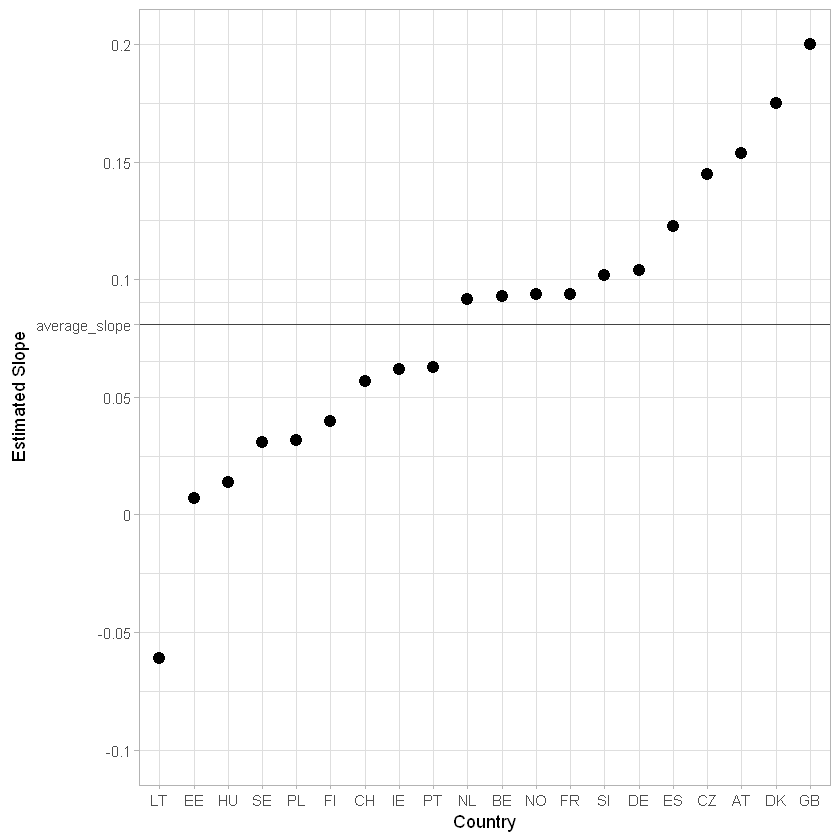

In [27]:
blups <- blups %>% arrange(Slope)
p <- ggplot(blups, aes(x=factor(Country, levels=Country), y=Slope+average_slope)) +
  geom_point(size=3) +
  labs(y = expression("Estimated Slope"), x = "Country")  +
  geom_hline(yintercept=average_slope, alpha=0.7) +
  scale_y_continuous(
    limits = c(-0.1,0.2),
    breaks = c(-0.1,-0.05,0,0.05,average_slope,0.1,0.15,0.2), 
    labels = c("-0.1","-0.05","0","0.05","average_slope","0.1","0.15","0.2")
  ) +
  theme_light() %+% theme(legend.position = "none")
p

ggsave("estimate_slope.png", dpi= 600, width = 6, height = 4)

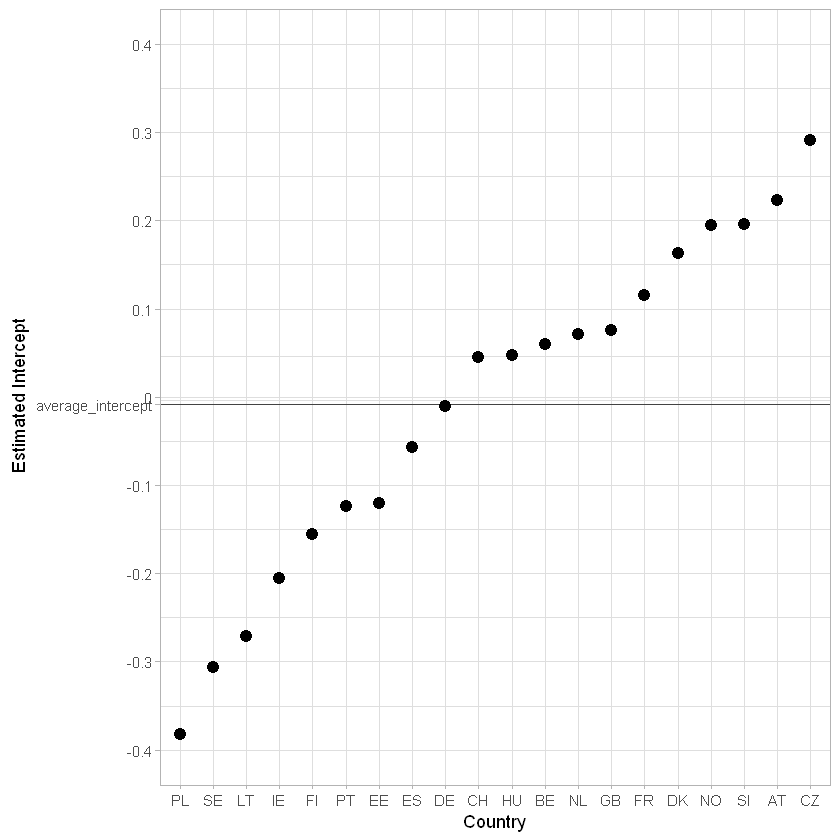

In [28]:
blups <- blups %>% arrange(Intercept)
p <- ggplot(blups, aes(x=factor(Country, levels=Country), y=Intercept+average_intercept)) +
  geom_point(size=3) +
  labs(y = expression("Estimated Intercept"), x = "Country")  +
  geom_hline(yintercept=average_intercept, alpha=0.7) +
  scale_y_continuous(
    limits = c(-0.4,0.4),
    breaks = c(-0.4,-0.3,-0.2,-0.1,0,average_intercept,0.1,0.2,0.3,0.4), 
    labels = c("-0.4","-0.3","-0.2","-0.1","0","average_intercept","0.1","0.2","0.3","0.4")
  ) +
  theme_light() %+% theme(legend.position = "none")
p

ggsave("estimate_intercept.png", dpi= 600, width = 6, height = 4)

In [29]:
data_after1 <- data %>% # Drop outliers
  filter(cntry != "CZ" & cntry != "LT" & 
           cntry != "SI" & cntry != "GB" & cntry != "DK")
ris_mod5 <- lmer(xeno ~ diff_rate*national_iden.j+age+education+friends+residence+media+econ_inse.j+(1+ diff_rate| cntry), data = data_after1,weights = pweights_a)
ris_mod5_t <- lmer_t(ris_mod5, method = "Heuristic") # Alternativelym, method = "Heuristic" for M-l-1 rule.
summary(ris_mod5_t)
ris_mod5_o <- texreg::extract(ris_mod5)
ris_mod5_o@pvalues <- summary(ris_mod5_t)$coef[,7]

Linear mixed model fit by REML ['lmerMod']
   t-tests use the Heuristic method.
Formula: xeno ~ diff_rate * national_iden.j + age + education + friends +  
    residence + media + econ_inse.j + (1 + diff_rate | cntry)
   Data: data_after1
Weights: pweights_a

REML criterion at convergence: 68548.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1304 -0.6103 -0.0145  0.5586  5.0570 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 cntry    (Intercept) 0.033271 0.1824       
          diff_rate   0.001521 0.0390   0.51
 Residual             0.819058 0.9050       
Number of obs: 25100, groups:  cntry, 15

Coefficients:
                          Estimate Std.Err t value    Df  Lower   Upper  
(Intercept)               -0.0369  0.0481   -0.7682    12 -0.1416  0.0678
diff_rate                  0.0715  0.0120    5.9485 25093  0.0479  0.0951
national_iden.j           -0.0600  0.0603   -0.9948    12 -0.1913  0.0714
age                        0.0127  0.0063    2.016

In [30]:
htmlreg(
  list(ris_mod4_o,ris_mod5_o), 
  file="without outliers.html", 
  include.ci = FALSE, 
  custom.coef.names = c(
    "Intercept",
    "Misperception",
    "National Identity",
    "Age",
    "Education",
     "Cross-ethnic Friends",
    "Residence",
        "Media Consumption",
      "Economic Insecurity",
      "National_Identity:Misperception"
  ),
  custom.model.names = c(
    "RIS Model","Without Outliers"
  ),
  groups = c(
    "Intercept" = list(1:1),
    "Individual level predictor" = list(2:2),
      "Country level predictor" = list(3:3),
          "Individual level control variables" = list(4:8),
      "Country level control variables" = list(9:9),
      "Cross-level interactions"= list(10:10)
    
  ),
  digits = 3,
  caption = "",
  custom.gof.rows = list("ICC" = c(
    paste0(round(icc(ris_mod4)*100, digits=2),"%"),
    paste0(round(icc(ris_mod5)*100, digits=2),"%")
  )
  )
)
webshot("without outliers.html", "without outliers.png")

The table was written to the file 'without outliers.html'.


